In [1]:
%reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [2]:
from capabilities import Capabilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlwings as xw
import os
for app in xw.apps: app.quit()

regions = ['TL', 'MPB', 'APB']
part_set_names = ['HT', 'WC', 'WD', 'AH', 'SA']

all_stats = {
    name: {
        'total_parts': 0,
        'unique_part_counts': {region: 0 for region in regions},
        'unique_part_percentages': {region: 0 for region in regions},
        'total_weight': 0,
        'weight_counts': {region: 0 for region in regions},
        'weight_percentages': {region: 0 for region in regions},
    }
    for name in part_set_names
}

Extracting dimensions from cost calculator. CWB example to start with.

In [3]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\VS_Cost_Calc.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\VS_Cost_Calc.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List').iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\EMedina\AppData\Local\anaconda3\envs\BAC\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
def get_parts_by_set(df, part_set):
    if isinstance(part_set, str): part_set = [part_set]
    return df[df['Part Set'].isin(part_set)].copy()

def get_part_stats(local_stats):
    for region_stats in local_stats:
        for part_set_name in region_stats:
            all_stats[part_set_name]['total_parts'] += region_stats[part_set_name]['total_parts']
            all_stats[part_set_name]['total_weight'] += region_stats[part_set_name]['total_weight']
            for region in regions:               
                all_stats[part_set_name]['unique_part_counts'][region] += region_stats[part_set_name]['unique_part_counts'][region]
                all_stats[part_set_name]['weight_counts'][region] += region_stats[part_set_name]['weight_counts'][region]

    for part_set_name, stats in all_stats.items():
        total_parts = stats['total_parts']
        total_weight = stats['total_weight']
        unique_part_percentages = {}
        weight_percentages = {}
        for region in regions:
            unique_part_counts = stats['unique_part_counts'][region]
            unique_part_percentages[region] = (unique_part_counts / total_parts * 100) if total_parts > 0 else 0.0
            all_stats[part_set_name]['unique_part_percentages'] = unique_part_percentages
            weight_counts = stats['weight_counts'][region]
            weight_percentages[region] = (weight_counts / total_weight * 100) if total_weight > 0 else 0.0
            all_stats[part_set_name]['weight_percentages'] = weight_percentages
            
def plot_pie_chart(data, title):
    region_colors = {
        'APB': '#66c2a5',
        'MPB': '#4f8cd6',
        'TL': '#e74c3c'
    }

    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(data.values(), labels=None, autopct='%1.1f%%', startangle=0, 
                                      colors=[region_colors[region] for region in data.keys()], 
                                      explode=[0.015] * len(data), textprops={'fontsize': 22, 'fontweight': 'bold'})
    plt.title(title, fontsize=28, fontweight='bold')
    plt.axis('equal')
    
    # Add legend in bottom right corner
    plt.legend(wedges, data.keys(), loc='lower right', bbox_to_anchor=(1, 0))
    
    plt.show()

def plot_stacked_bar_chart(all_stats, title):
    """
    Plot a horizontal stacked bar chart with 3 colors (MPB, APB, TL) for each part set,
    ranked in descending order by MPB weight, and add percentage labels.

    Args:
        all_stats (dict): Dictionary containing stats for each part set.
        title (str): Title of the bar chart.
    """

    # Define regions and their colors
    regions = ['MPB', 'APB', 'TL']
    region_colors = {
        'APB': '#66c2a5',
        'MPB': '#4f8cd6',
        'TL': '#e74c3c'
    }

    # Remove 'HT' from part sets
    filtered_stats = {k: v for k, v in all_stats.items() if k != 'HT'}

    # Rank part sets by MPB weight in descending order
    ranked_part_sets = sorted(
        filtered_stats.keys(),
        key=lambda part_set: filtered_stats[part_set]['weight_counts']['MPB'],
        reverse=False
    )

    # Extract data for the bar chart
    part_sets = ranked_part_sets
    total_weights = [filtered_stats[part_set]['total_weight'] for part_set in part_sets]
    region_weights = {
        region: [filtered_stats[part_set]['weight_counts'][region] for part_set in part_sets]
        for region in regions
    }

    # Create a horizontal stacked bar chart
    y = np.arange(len(part_sets))  # Y-axis positions
    bar_height = 0.6

    fig, ax = plt.subplots(figsize=(10, 8))
    left = np.zeros(len(part_sets))  # Initialize the left position of the bars

    for region in regions:
        ax.barh(
            y, region_weights[region], bar_height,
            label=region, color=region_colors[region],
            left=left
        )
        left += np.array(region_weights[region])  # Update the left position for stacking

    # Add percentage labels to the bars
    for i, part_set in enumerate(part_sets):
        total_weight = total_weights[i]
        if total_weight > 0:
            left_position = 0  # Initialize the left position for centering
            for region in regions:
                region_weight = filtered_stats[part_set]['weight_counts'][region]
                percentage = (region_weight / total_weight) * 100
                if region_weight > 0:
                    # Calculate the center of the current region segment
                    x_position = left_position + region_weight / 2
                    ax.text(
                        x_position, i, f'{percentage:.0f}%', ha='center', va='center', fontsize=14, color='white', fontweight='bold'
                    )
                left_position += region_weight  # Update the left position for the next region

    # Add labels, title, and legend
    ax.set_yticks(y)
    # ax.set_xticks([])
    ax.set_yticklabels(part_sets, fontsize=14, fontweight='bold')

    ax.set_xlabel('Weight', fontsize=16, fontweight='bold')
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.legend(title='Mfg Method', fontsize=14, loc='lower right')

    plt.tight_layout()
    plt.show()

part_sets = []
for part_set in df['Part Set'].dropna().unique(): 
    part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))

# Plot manufacturing regions per material and gauge

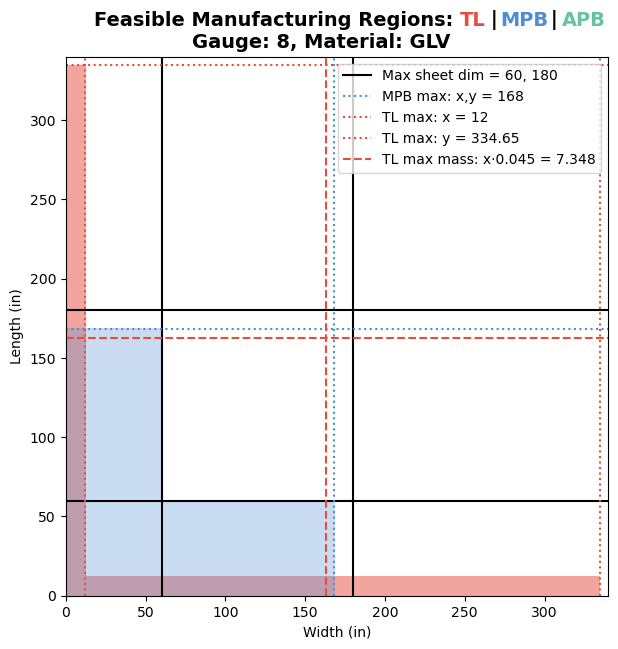

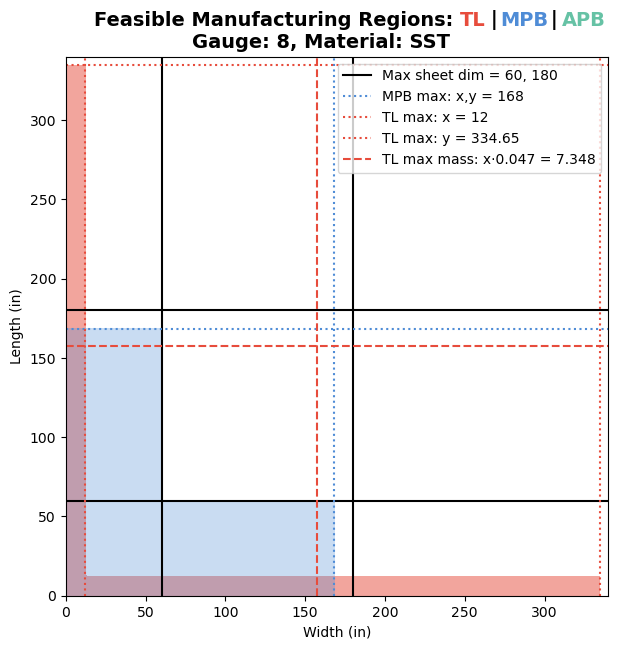

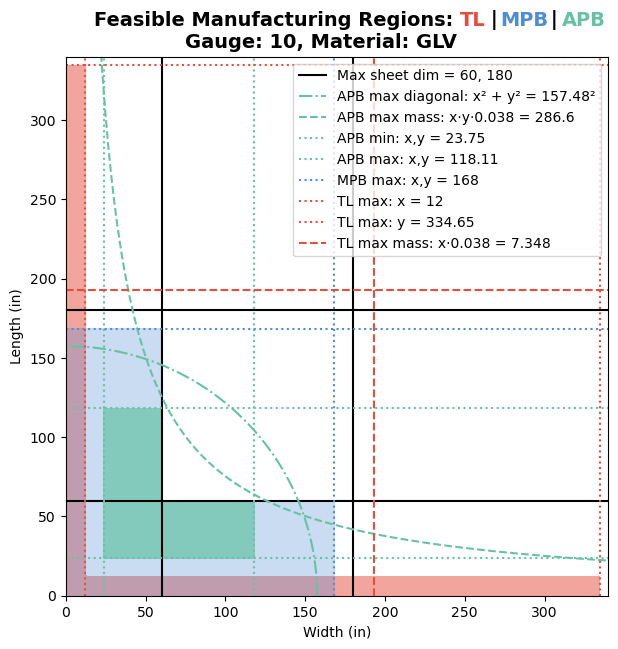

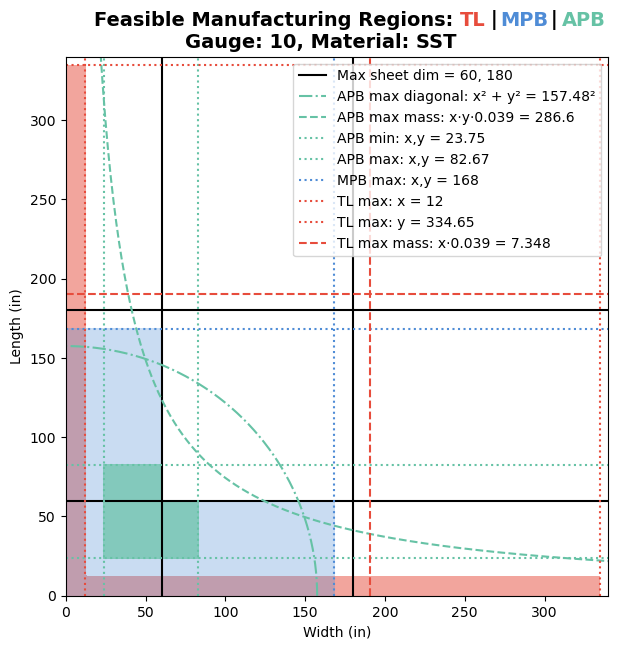

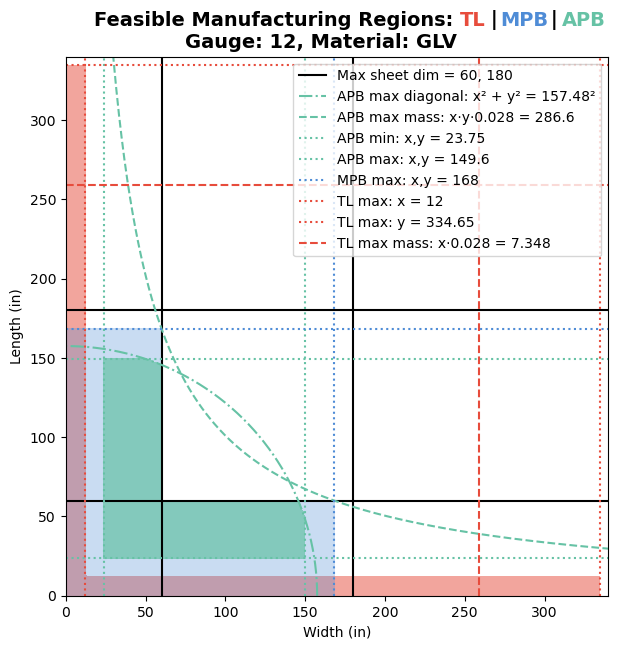

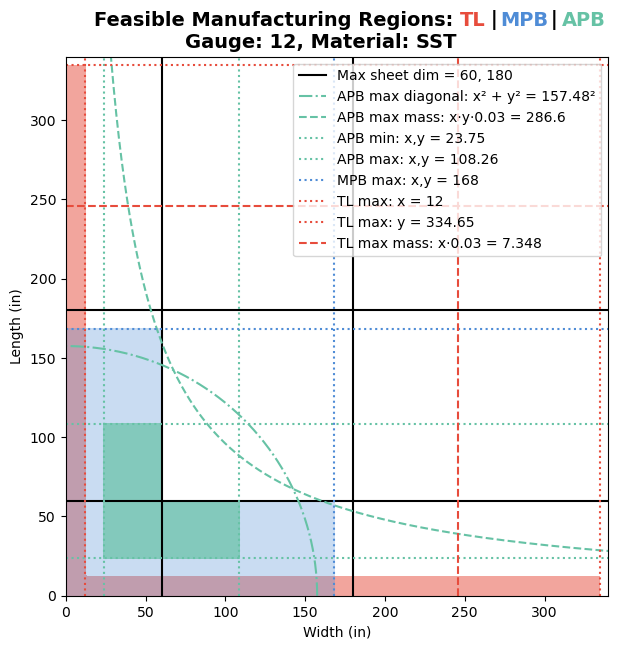

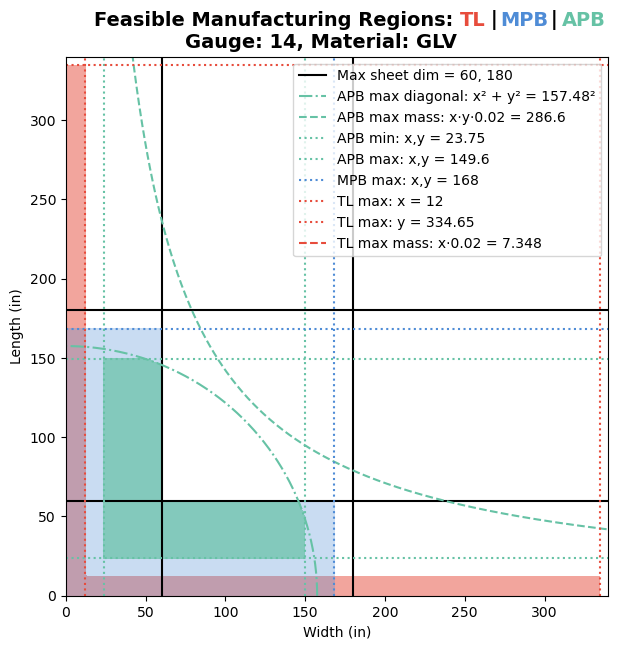

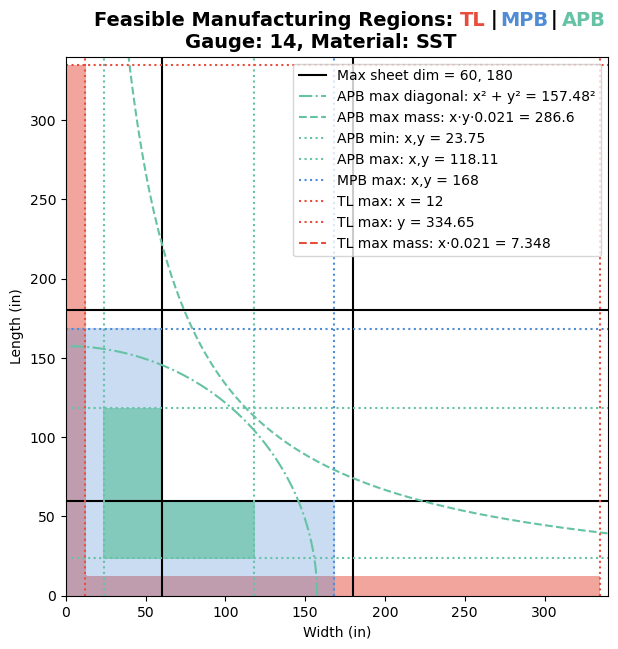

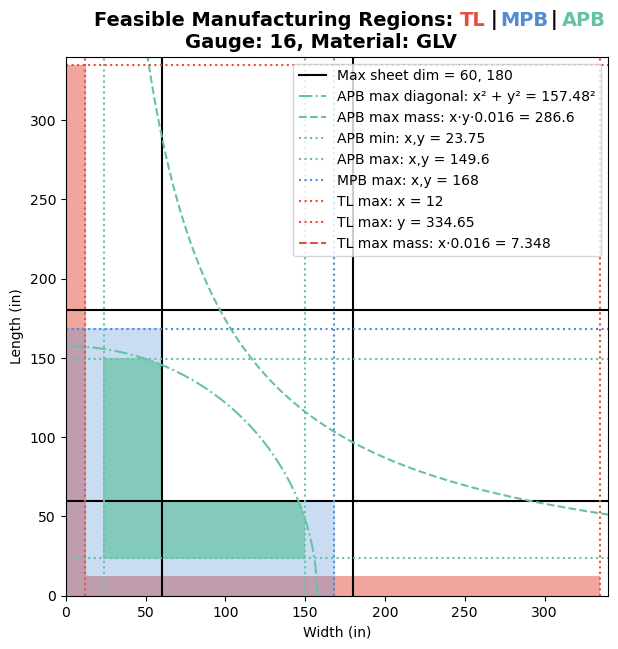

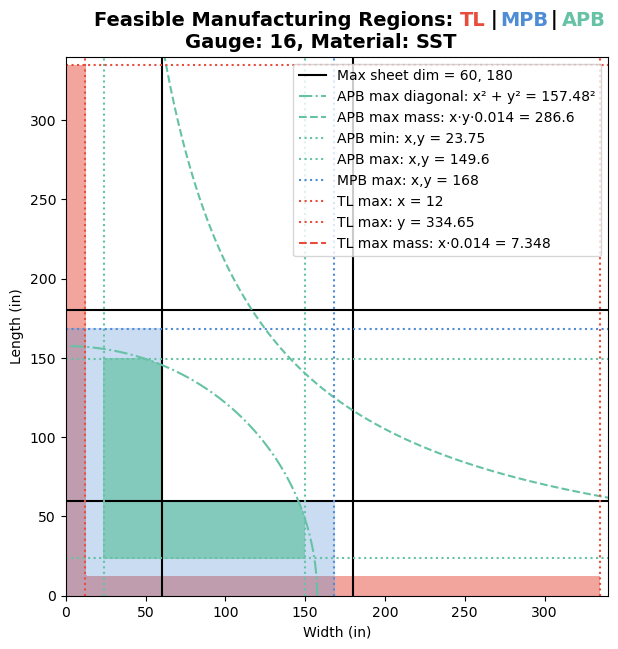

In [5]:
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        part_set_stats = cap.add_part_sets(part_sets, get_stats=True)
        get_part_stats(part_set_stats)

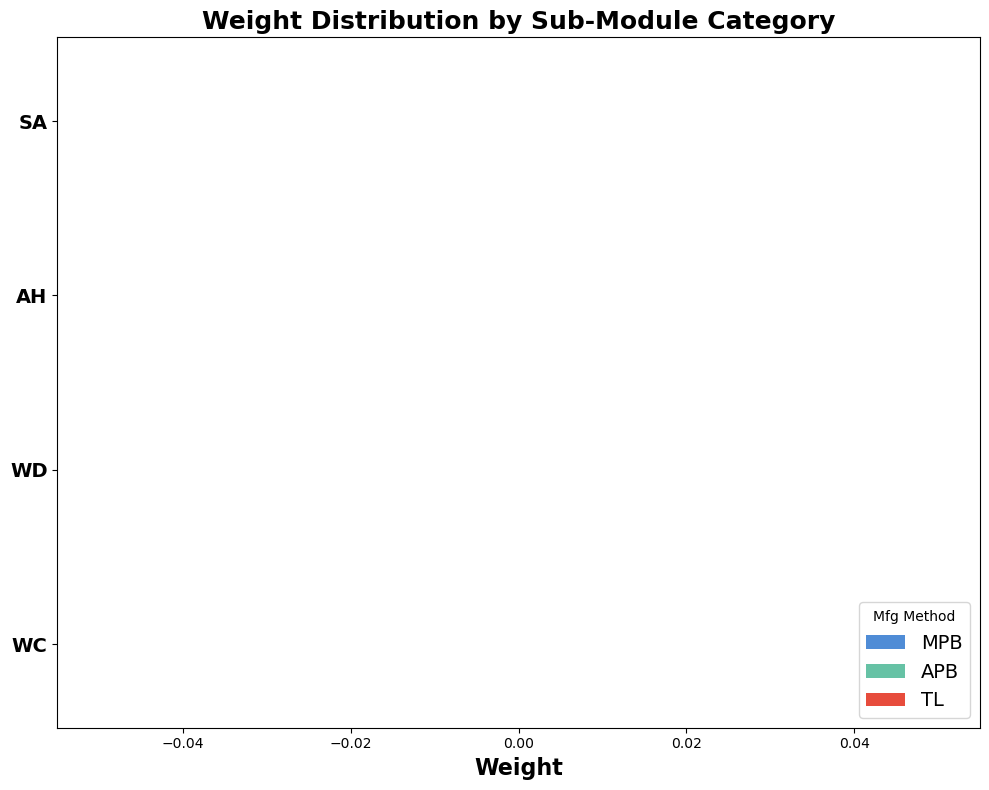

In [6]:
# for submodule in all_stats.keys():
#     if all_stats[submodule]['total_parts'] == 0:
#         continue
#     plot_pie_chart(all_stats[submodule]['weight_counts'], f'Weight in {submodule}')

# Plot the total weight distribution for each part set
plot_stacked_bar_chart(all_stats, 'Weight Distribution by Sub-Module Category')

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 0
No feasible points for this region.
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 520
    • Optimal area: 12,626 sq in
    • Cost per sq in: $8.6476
  Cost Distribution:
    • Minimum cost: $36.59
    • Maximum cost: $477.68
    • Avera

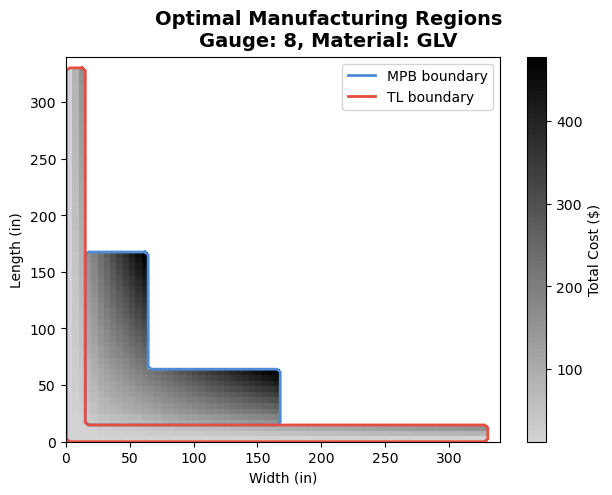

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 0
No feasible points for this region.
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...
Found 195 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB REGION: Never optimal in competitive areas

TL 

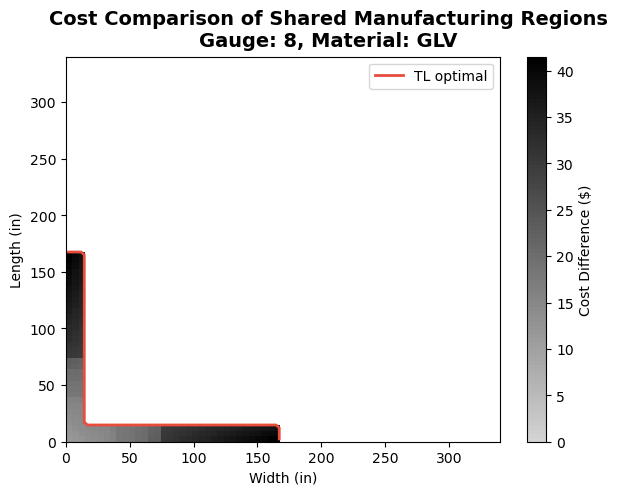

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 0
No feasible points for this region.
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 520
    • Optimal area: 12,626 sq in
    • Cost per sq in: $19.3943
  Cost Distribution:
    • Minimum cost: $50.78
    • Maximum cost: $1175.42
    • Ave

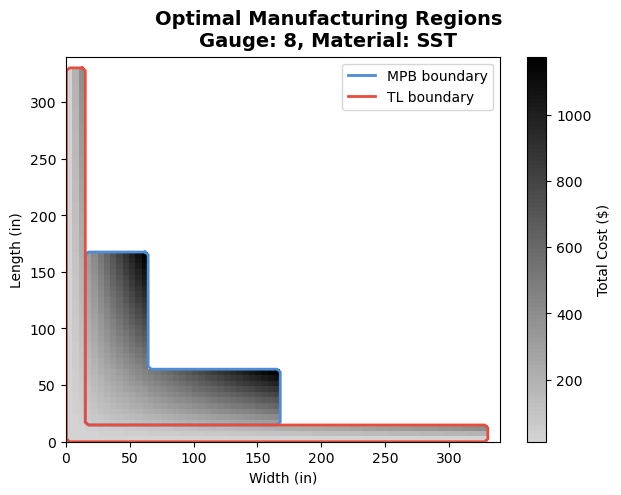

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 0
No feasible points for this region.
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...
Found 195 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB REGION: Never optimal in competitive areas

TL 

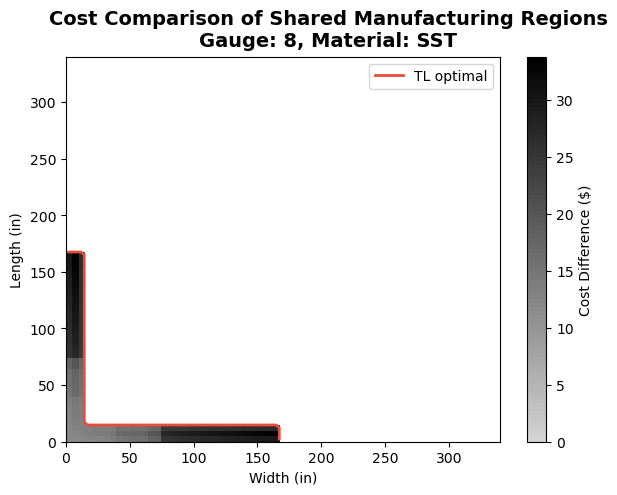

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 240
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 389...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 240 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

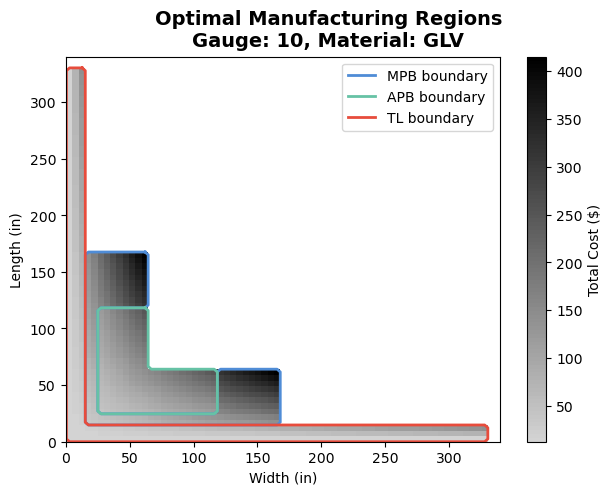

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 240
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 389...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 240 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

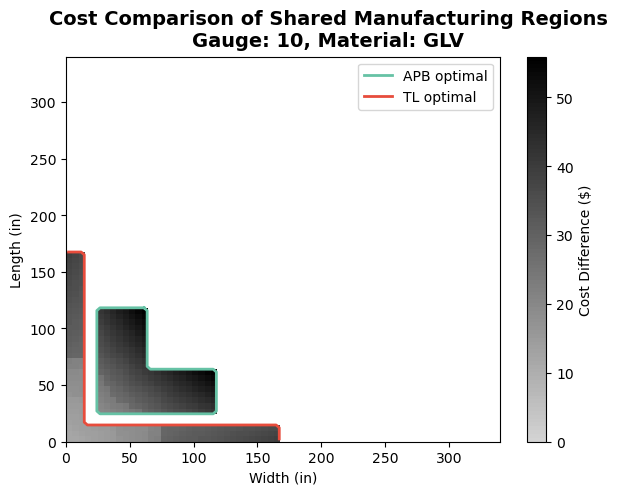

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 128
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 277...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 128 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

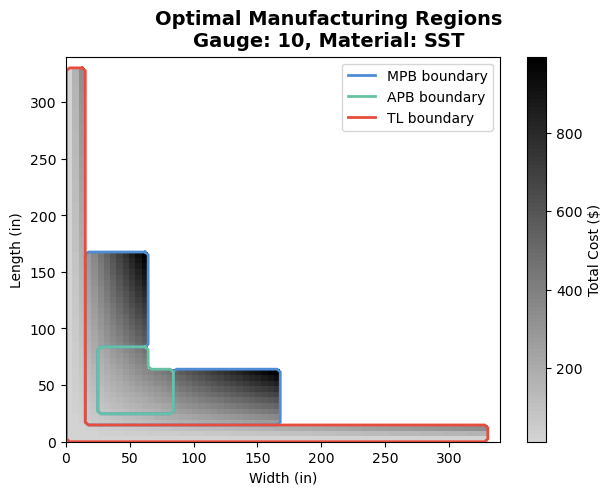

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 128
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 277...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 128 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

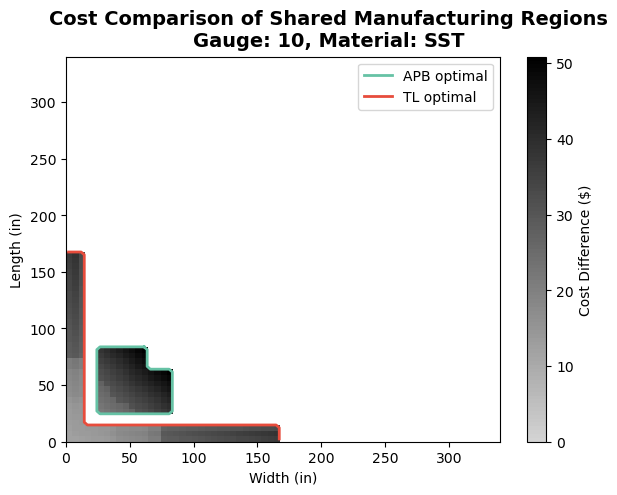

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

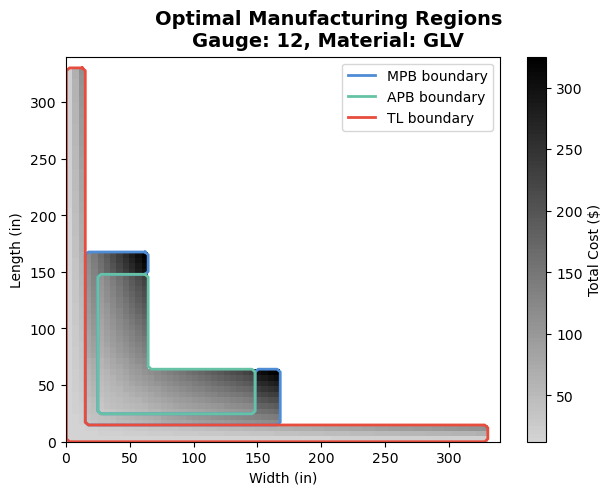

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

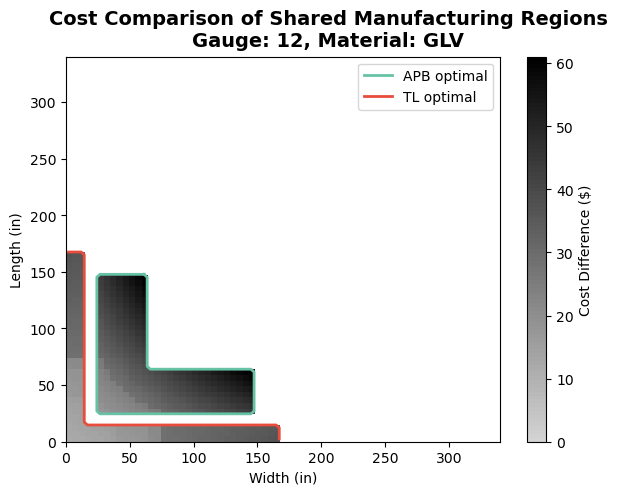

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 208
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 357...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 208 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

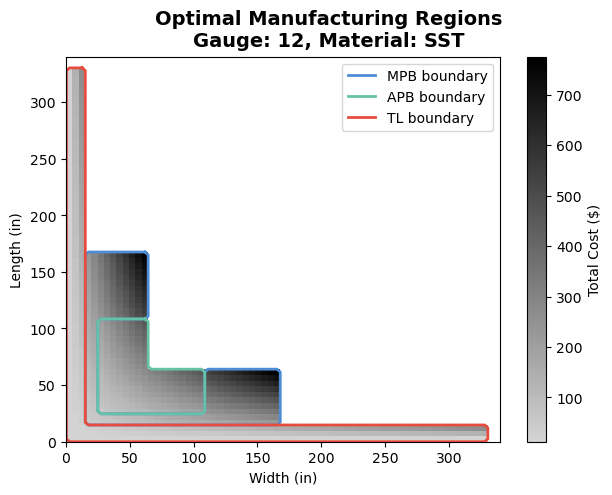

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 208
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 357...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 208 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

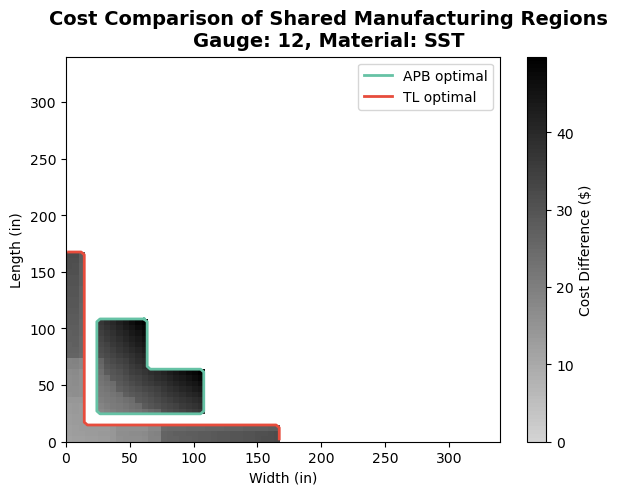

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

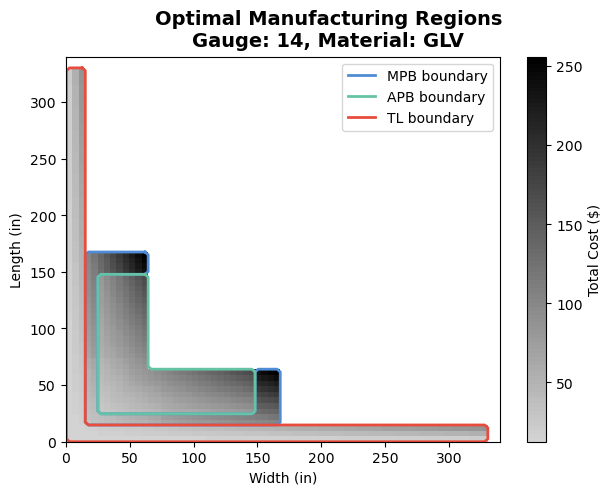

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

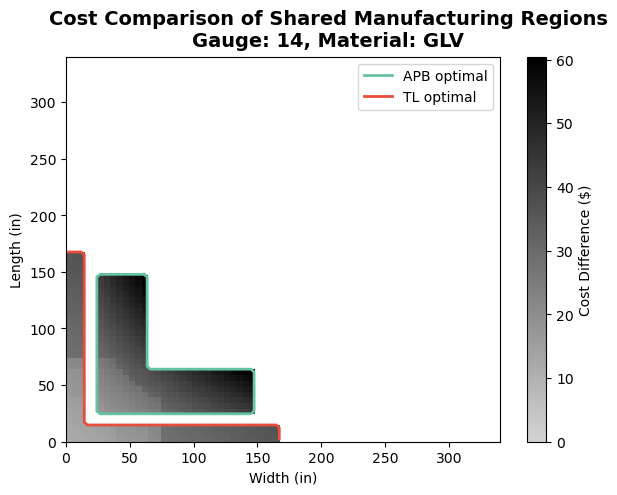

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 240
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 389...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 240 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

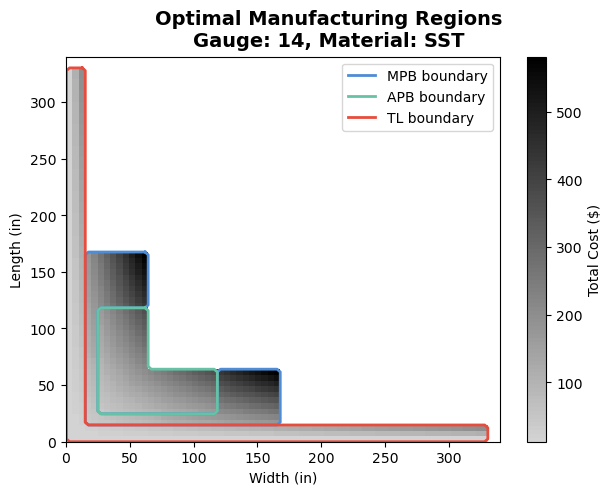

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 240
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 389...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 240 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

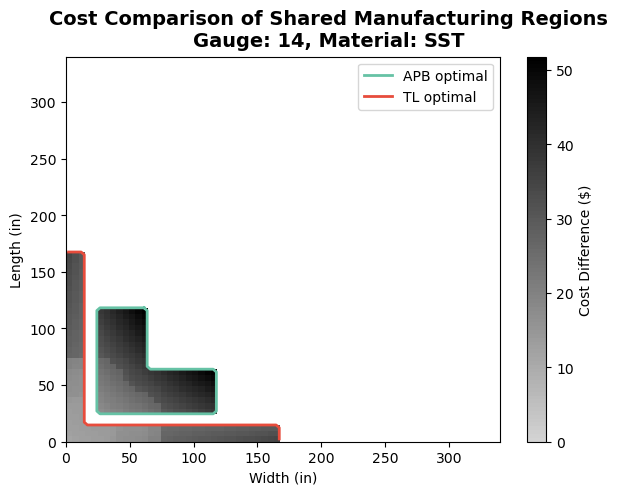

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

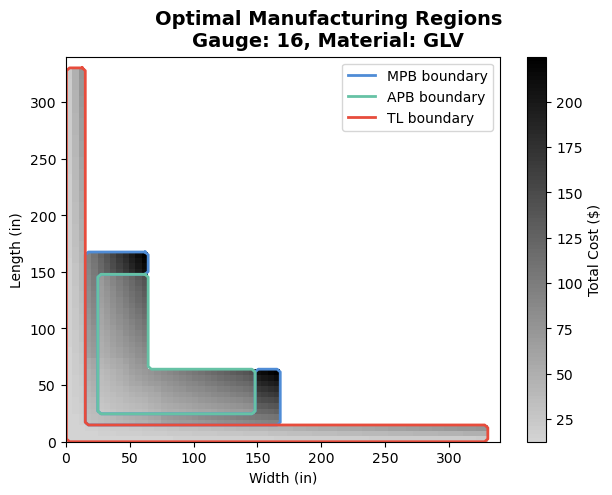

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

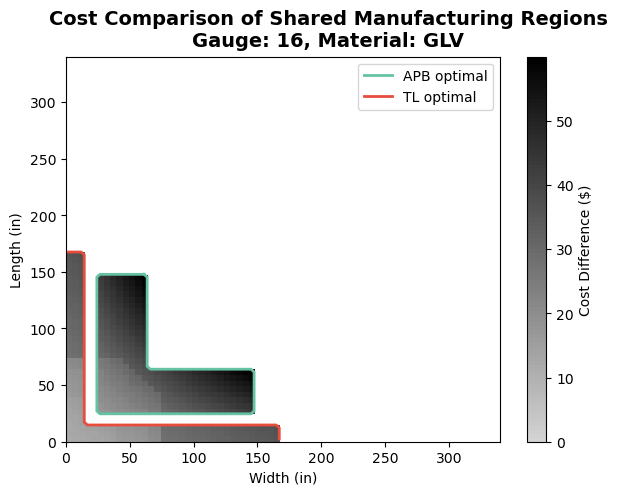

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

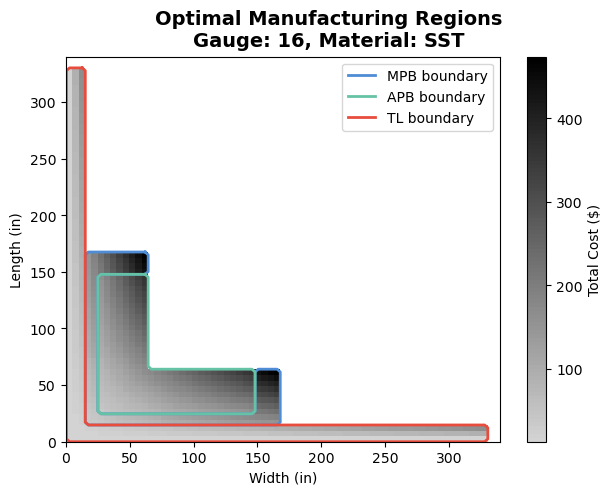

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 336
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 485...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 336 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 393
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 542...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 393 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

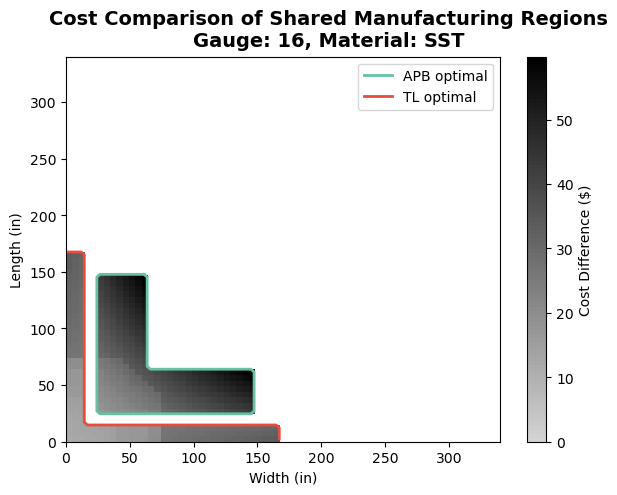

In [7]:
for app in xw.apps:
    app.quit()

# # Diagonal increase from (40,30) to (100,80)
# cap = Capabilities('GLV', 10)
# results = cap.plot_cost_run_chart(path, 5, 5, 55, 55, 'diagonal', 5)

gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        # cap.plot_individual_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
        cap.plot_optimal_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
        cap.plot_cost_difference_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)